In [1]:
import yfinance as yf
import pandas as pd

In [2]:
import mplfinance as fplt
import talib # pip install TA-Lib

print("TA-Lib Version : {}".format(talib.__version__))
print("MPLFinance Version : {}".format(fplt.__version__))

TA-Lib Version : 0.4.28
MPLFinance Version : 0.12.10b0


In [3]:
# Example usage
symbols = {
            "AMD": (20, "$"),
            "ABEA.DE": (42, "€"),
            "AMZN": (75, "€"),
            "ARM": (30, "$"),
            "ASML": (10, "$"),
            #"BSI.MU": (51, "€"),
            "BTC-USD": (0.025, "$"),
            "CRM": (7, "$"),
            #"DDOG": (7, "$"),
            "ETH-USD": (0.493, "$"),
            "KLAC": (3, "$"),
            #"MDB": (5, "$"),
            "META": (15, "$"),
            #"MSFT": (6, "$"),
            "NVDA": (13, "$"),
            #"ISRG": (3, "$"),
            "QCOM": (20, "$"),
            #"RDC.DE": (10, "€"),
            #"RHM.DE": (5, "€"),
            #"SAAB-B.ST": (19, "SEK"),
            #"SHL.DE": (19, "€"),
            #"SMCI": (6, "$"),
            "TSFA.F": (17, "$"),
            "DTE.DE": (0, "€"),
            "^GSPC": (0, "$"),
           }
df = yf.download(list(symbols.keys()), period="1y")

[*********************100%%**********************]  15 of 15 completed


In [4]:
for symbol in symbols:
    df["SMA50", symbol] = df["Adj Close", symbol].rolling(50).mean()
    df["SMA200", symbol] = df["Adj Close", symbol].rolling(200).mean()
    # df["RSI", symbol] = talib.RSI(df["Adj Close", symbol], timeperiod=3)
    df["EMA", symbol] = df["Adj Close", symbol].ewm(span=50, adjust=False).mean()
    df["Adj Daily Return", symbol] = df["Adj Close", symbol].pct_change()
    df["Cum Adj Daily Return", symbol] = df["Adj Daily Return", symbol].cumsum()

/tmp/ipykernel_1081640/305460361.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["Adj Daily Return", symbol] = df["Adj Close", symbol].pct_change()
/tmp/ipykernel_1081640/305460361.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["Adj Daily Return", symbol] = df["Adj Close", symbol].pct_change()
/tmp/ipykernel_1081640/305460361.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `n

In [5]:
df.head(1)

Price      Adj Close                                                         \
Ticker       ABEA.DE AMD AMZN ARM ASML       BTC-USD CRM DTE.DE     ETH-USD   
Date                                                                          
2023-03-05       NaN NaN  NaN NaN  NaN  22435.513672 NaN    NaN  1564.46875   

Price            ...  SMA50 SMA200    EMA Adj Daily Return  \
Ticker     KLAC  ... DTE.DE DTE.DE DTE.DE           DTE.DE   
Date             ...                                         
2023-03-05  NaN  ...    NaN    NaN    NaN              NaN   

Price      Cum Adj Daily Return SMA50 SMA200   EMA Adj Daily Return  \
Ticker                   DTE.DE ^GSPC  ^GSPC ^GSPC            ^GSPC   
Date                                                                  
2023-03-05                  NaN   NaN    NaN   NaN              NaN   

Price      Cum Adj Daily Return  
Ticker                    ^GSPC  
Date                             
2023-03-05                  NaN  

[1 rows x 165 columns]

In [6]:
round(df["Adj Daily Return"].iloc[-1] * 100, 2)

Ticker
AMD        0.00
ABEA.DE    0.00
AMZN       0.00
ARM        0.00
ASML       0.00
BTC-USD    6.71
CRM        0.00
ETH-USD    5.53
KLAC       0.00
META       0.00
NVDA       0.00
QCOM       0.00
TSFA.F     0.00
DTE.DE     0.00
^GSPC      0.00
Name: 2024-03-05 00:00:00, dtype: float64

In [7]:
sek_factor = yf.download("SEK=X", period="1d").iloc[-1]["Adj Close"]
euro_factor = yf.download("EURUSD=X", period="1d").iloc[-1]["Adj Close"]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [8]:
sek_factor

10.377019882202148

In [9]:
euro_factor

1.0853049755096436

In [20]:
total_portfolio_value = 0
for day in df.index:
    if not day.weekday() < 5:
        continue
    total_portfolio_value = 0
    for ticker, (amount_shares, currency) in symbols.items():
        last_price = df["Adj Close", ticker].loc[day]
        if pd.isna(last_price):
            last_price = 0
        if currency == "€":
            last_price /= euro_factor
        if currency == "SEK":
            last_price /= sek_factor
        # print(ticker, " $ value: ", round(amount_shares * last_price))
        # print(ticker, "€:", amount_shares * last_price / euro_factor)
        total_portfolio_value += amount_shares * last_price 
        df.loc[day, "Total Portfolio Value"] = total_portfolio_value
    #print("Total $: ", total_portfolio_value)

print("Total €", round(total_portfolio_value / euro_factor))


Total € 58624


In [21]:
df = df[df["Total Portfolio Value"] > 30000]

<AxesSubplot:xlabel='Date'>

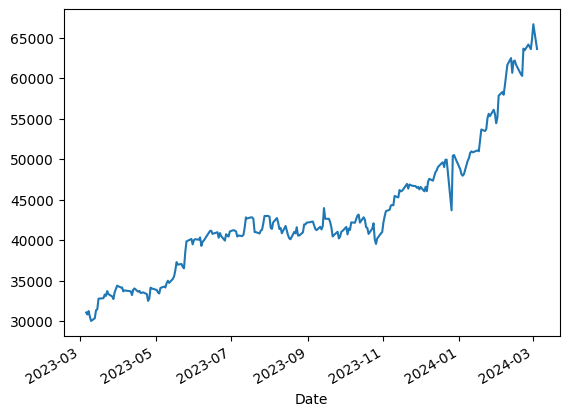

In [22]:
df["Total Portfolio Value"].plot()

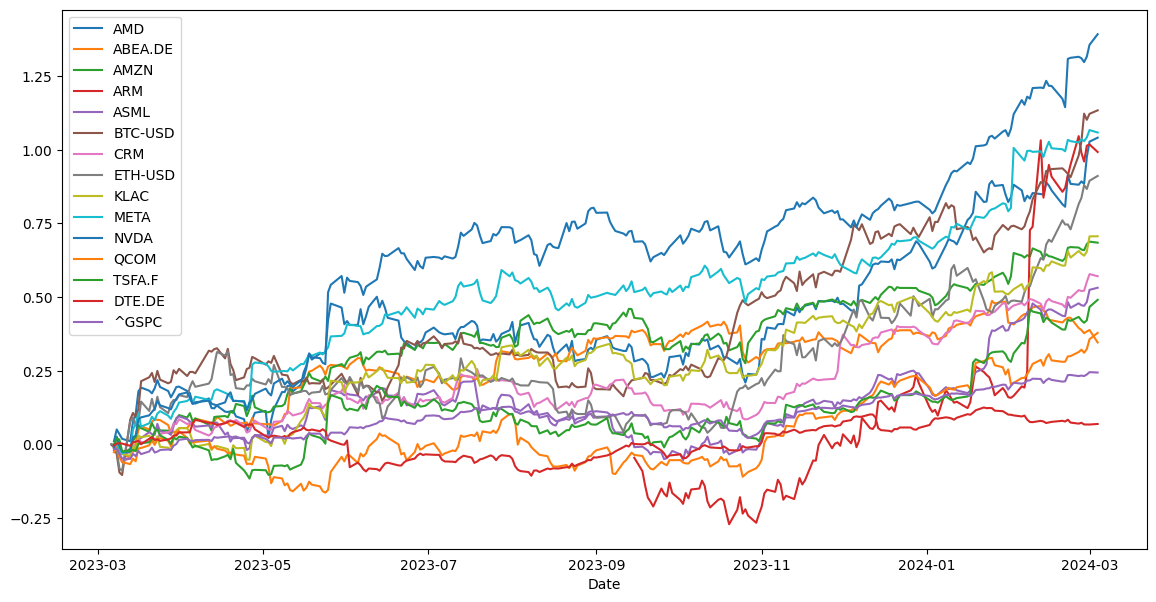

In [13]:
from matplotlib import pyplot as plt
plt.figure(figsize=(14,7))
plt.plot(df['Cum Adj Daily Return'])
plt.xlabel('Date')
plt.legend(symbols)
plt.show()

In [14]:
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime, timedelta

for i in range(1, 5):
    # Calculate the date i weeks ago
    three_months_ago = datetime.today() - timedelta(days=i*7)
    # Convert the date to a string in the desired format
    date_string = three_months_ago.strftime("%Y-%m-%d")
    tmp = df[df.index >= date_string].copy()

    for symbol in symbols:
        tmp["Cum Adj Daily Return", symbol] = tmp["Adj Daily Return", symbol].cumsum()

    # Create a scatter plot
    fig = px.line(tmp['Cum Adj Daily Return'], title=f"week {i}")
    # Show the plot
    fig.show()

In [15]:
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime, timedelta

for i in range(1, int(200/7), 4):
    # Calculate the date i weeks ago
    three_months_ago = datetime.today() - timedelta(days=i*7)
    # Convert the date to a string in the desired format
    date_string = three_months_ago.strftime("%Y-%m-%d")
    tmp = df[df.index >= date_string].copy()

    for symbol in symbols:
        tmp["Cum Adj Daily Return", symbol] = (tmp["Adj Daily Return", symbol] - tmp["Adj Daily Return", "^GSPC"]).cumsum()

    # Create a scatter plot
    fig = px.line(tmp['Cum Adj Daily Return'], title=f"week {i}")
    # Show the plot
    fig.show()


In [16]:
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime, timedelta

for i in range(1, 30, 3):
    # Calculate the date i months ago
    three_months_ago = datetime.today() - timedelta(days=i*30)
    # Convert the date to a string in the desired format
    date_string = three_months_ago.strftime("%Y-%m-%d")
    tmp = df[df.index >= date_string].copy()

    for symbol in symbols:
        tmp["Cum Adj Daily Return", symbol] = (tmp["Adj Daily Return", symbol] - tmp["Adj Daily Return", "^GSPC"]).cumsum()

    # Create a scatter plot
    fig = px.line(tmp['Cum Adj Daily Return'], title=f"month {i}")
    # Show the plot
    fig.show()


In [17]:
import itertools
import string

ticker_letters = string.ascii_uppercase

def foo(l):
     yield from itertools.product(*([l] * 3)) 

for x in foo(ticker_letters):
     # print(''.join(x))
     pass

In [18]:
msft = yf.Ticker("MSFT")

# get all stock info
msft.info

# get historical market data
hist = msft.history(period="1mo")

# show meta information about the history (requires history() to be called first)
msft.history_metadata

# show actions (dividends, splits, capital gains)
msft.actions
msft.dividends
msft.splits
msft.capital_gains  # only for mutual funds & etfs

# show share count
msft.get_shares_full(start="2022-01-01", end=None)

# show financials:
# - income statement
msft.income_stmt
msft.quarterly_income_stmt
# - balance sheet
msft.balance_sheet
msft.quarterly_balance_sheet
# - cash flow statement
msft.cashflow
msft.quarterly_cashflow
# see `Ticker.get_income_stmt()` for more options

# show holders
msft.major_holders
msft.institutional_holders
msft.mutualfund_holders
msft.insider_transactions
msft.insider_purchases
msft.insider_roster_holders

# show recommendations
msft.recommendations
msft.recommendations_summary
msft.upgrades_downgrades

# Show future and historic earnings dates, returns at most next 4 quarters and last 8 quarters by default. 
# Note: If more are needed use msft.get_earnings_dates(limit=XX) with increased limit argument.
msft.earnings_dates

# show ISIN code - *experimental*
# ISIN = International Securities Identification Number
msft.isin

# show options expirations
msft.options

# show news
msft.news

# get option chain for specific expiration
#opt = msft.option_chain('YYYY-MM-DD')

[{'uuid': 'f991c58b-5f14-33cc-a2b9-69357a6b3236',
  'title': 'Dow Jones Futures: AI Stocks Nvidia, Super Micro Surge To New Highs; Apple, Google, Tesla Stock Sell Off',
  'publisher': "Investor's Business Daily",
  'link': 'https://finance.yahoo.com/m/f991c58b-5f14-33cc-a2b9-69357a6b3236/dow-jones-futures%3A-ai-stocks.html',
  'providerPublishTime': 1709600611,
  'type': 'STORY',
  'thumbnail': {'resolutions': [{'url': 'https://s.yimg.com/uu/api/res/1.2/HDjemjYlp7Z5vRwiz3dW9Q--~B/aD01NjM7dz0xMDAwO2FwcGlkPXl0YWNoeW9u/https://media.zenfs.com/en/ibd.com/8e3f0f90c622d76c522be98b9f3975ee',
     'width': 1000,
     'height': 563,
     'tag': 'original'},
    {'url': 'https://s.yimg.com/uu/api/res/1.2/udkt6p.2GFTMNRqe6zXG_A--~B/Zmk9ZmlsbDtoPTE0MDtweW9mZj0wO3c9MTQwO2FwcGlkPXl0YWNoeW9u/https://media.zenfs.com/en/ibd.com/8e3f0f90c622d76c522be98b9f3975ee',
     'width': 140,
     'height': 140,
     'tag': '140x140'}]},
  'relatedTickers': ['^DJI',
   'AAPL',
   '^GSPC',
   'TSLA',
   'NVDA',
   

In [19]:
msft.earnings_dates

,EPS Estimate,Reported EPS,Surprise(%)
Earnings Date,,,
2025-01-28 16:00:00-05:00,NaN,NaN,NaN
2024-10-22 06:00:00-04:00,NaN,NaN,NaN
2024-07-23 06:00:00-04:00,NaN,NaN,NaN
2024-04-23 06:00:00-04:00,2.60,NaN,NaN
2024-01-30 16:00:00-05:00,2.78,2.93,0.0534
2023-10-24 16:00:00-04:00,2.65,2.99,0.1270
2023-07-25 16:00:00-04:00,2.55,2.69,0.0549
2023-04-25 16:00:00-04:00,2.23,2.45,0.0981
2023-01-24 16:00:00-05:00,2.29,2.32,0.0109
